In [2]:
# GENERIC LIBRARIES #####
from matplotlib import pyplot as plt # type: ignore
import numpy as np
import emcee
import seaborn as sns
import pandas as pd

import corner

#other useful features
from inspect import signature
from numpy import log10
from numpy import log
from numpy import pi
from numpy import sqrt
from scipy.optimize import minimize
from numpy import sqrt, pi, sin, cos, log, exp, euler_gamma
from scipy.interpolate import RectBivariateSpline
#from IPython.display import display, Math
#plt.rcParams['text.usetex'] = True

from numpy import exp
import warnings

#from scipy.optimize import curve_fit
#from scipy.integrate import quad
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'


In [3]:
#Useful constants in SI

hbar = 1.054571817e-34 #reduced Planck constant
e = 1.60217662e-19 #elementary charge
c0 = 2.99792458e8 #speed of light in vacuum
G = 6.67430e-11 #Gravitational constant
#Solar mass
sm = 1.98847e30
#Parsec
pc = 3.0856775814913673e16

#length scale of natural units
evm = hbar*c0/e
#time scale of natural units
evs = hbar/e
#mass scale of natural units
evkg = e/c0**2

#Hubble constant (km/s/Mpc)
H = 67.8

#Reduced Hubble constant
h = H/100

om = 0.284 # matter density parameter
pcrit = 3*(H*1000/(1e6*pc))**2/(8*np.pi*G) #cosmological matter density

pom = om*pcrit #cosmological matter density

#Relevant quantities in natural units (hbar = 1, c0 = 1)

#gravitational constant
evG = G*e**2/(c0**5*hbar)
#Planck mass
evMpl = 1/sqrt(evG)
#Hubble constant
evH = H*1000/(pc*1e6)*hbar/e
#Cosmological critical density
rc = 3*evH**2/(8*np.pi*evG)
#NFW characteristic radius
#evrs = rs/evm
#Solar mass
evsm = sm/evkg
#Parsec
evpc=pc/evm

evpom = pom*(evm**3)/evkg #cosmological matter density
size = 25


c = 3e+5 #Light speed in km/s
G = 4.3e-3 # In units of pc/Ms * (km/s)^2
h = 0.674
rho_c = 2.7754e-7*h**2 # In units of Ms/Mpc-3
GeVtocm2 = (1/5.06e13)**2 # cm^2
GeVtog = (1/1.78e-24)



In [4]:
# optimizer function: looks for a finite-value log-probability optimum
#It works by perturbing the initial guess with sigma normal
#fluctuations (sig*100 is the percentage relative to the mean), 
#it then uses the scipy optimizer to find finite local 
#maxima of the probability and selects the best of those to get
# an estimate of the global one

def optimizer(name, lpost, init, ndim, stps, sig, period = 100):
        
        params = []
        nlprobs = []
        init0 = init
        
        filname = 'Data.dat'
        
        #Extract Data
        V   = np.loadtxt(filname, usecols = 1)
        VL  = np.loadtxt(filname, usecols = 2)
        VR  = np.loadtxt(filname, usecols = 3)
        EV  = V-VL
        S   = np.loadtxt(filname, usecols = 4)
        SD  = np.loadtxt(filname, usecols = 5)
        SU  = np.loadtxt(filname, usecols = 6)
        ES  = S-SD
        
        nll = lambda *args: - lpost(*args) #returns the negative of the log-posterior
        

        for t in range(3):
            sig *= 2**(t)
            for i in range(stps):
                if i%period == 0:
                    init = init0
                rand = np.random.randn(ndim)

                for j in range(ndim):
                        rand[j] *= sig*init[j]
               
                soln = minimize(nll, init, args=(V, S, ES, EV))
                init = soln.x
                nlpr = nll(init, V, S, ES, EV);

                if np.isfinite(nlpr): 

                          params.append(init)
                          nlprobs.append(nlpr)

        if len(nlprobs) == 0:
            print("No viable log-probability optimisation found:")
            print( " ")
            print(init)
            return init0
        
        mlprob = np.inf
        
        for k in range(len(nlprobs)):
            if nlprobs[k] < mlprob:
                mlprob = nlprobs[k]
                init = params[k]
                
        for n in range(len(nlprobs)):
            if nlprobs[n] < 1.25*mlprob and max(abs(params[n] - init)) > 1:
                print("Alternative optimum at ", params[n])     
                
        print("Log-probability optimum found:")
        print( " ")
        print(init, "[log-prob. = ", -mlprob, "]")
        return init

In [5]:

"""
///////////// Plot Settings ///////////////
"""
#Global Setting

#sns.set_style('ticks') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('axes', linewidth=1.25 )   # width of the frame
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=14)          # controls default text sizes

#Latex rendering
#plt.rc('font', **{'family': 'serif', 'serif': ['Modern Computer']})
#plt.rc('text', usetex=True)
#plt.rc('font', weight='bold')

#Colors:

RegionAlpha = 0.6
MainColor1 = (29/255, 36/255, 164/255) #Blue
MainColor2 = (155/255, 8/255, 0/255) # Red
MainColor3 = (212/255, 58/255, 0) # Orange
BackgroundColor1 = (29/255, 62/255, 64/255) #Dark Blue
BackgroundColor2 = (0.467,0.137,0.184) # Dark Red
BackgroundColor3 = (253/255, 191/255, 92/255) # Dark Yellow 
Gray1 = (0.337,0.352,0.360) #Darker Gray
Gray2 = (0.694,0.698,0.690) # 


#convertion factor
fc = GeVtocm2*GeVtog

## Target function

Siempre la funcion para el ajuste es sigmav

In [6]:


def sigmav(mchi, mphi, V):
    alphax = 0.01
    w  = 300*(mphi/(10))*(10/(mchi))
    Beta_array = V/w
    st = (275.73)*(alphax/0.01)**2*(mchi/10.0)*(10.0/(mphi))**(4)

    for beta in Beta_array:
        
        if beta < 0.01:
            sv = 3/6*st
        else:
            sv = 3*st*(1/beta**6)*( (2+beta**2)*np.log(1+ beta**2)- 2*beta**2 )

    return sv

def sigmat(mchi, mphi, V):
    alphax = 0.01 
    w = 300 * (mphi / 10) * (10 / mchi)
    st = (275.73) * (alphax / 1e-2) ** 2 * (mchi / 10) * (10 / mphi) ** (4)
    sv = 2 * st * (w ** 4 / V ** 4) * (2 * np.log(1.0 + V ** 2 / (2 * w ** 2)) - np.log(1.0 + V ** 2 / (w ** 2)))
    return sv


def omega(mchi, mphi):
    w  = 300*(mphi/(10))*(10/(mchi))
    return w

# Logarithm of the prior probability. This is saying the probability is not
# zero only in the range -10 < theta < 10, where theta are the parameters
def logp(lmchi, lalpha):
    if -10 < lmchi < 10 and -10 < lalpha < 10:
        return 0.0
    return -np.inf    

## Fit with Viscosity Cross Section

In [7]:


def GOPT(name, init, nwalkers = 48, 
           steps = 2000, burn = 0, opstps = 1000, sig = 0.1, sigp = 0.1):
        
        #DM only rotation curve
        def smodel(theta, V):
            param = np.copy(theta)
            param = 10**param
            return sigmav(*param,V)

        #log-prior, here theta = (lmchi, lalpha)
        def lprior(theta, V):
            return logp(*theta)

        #log-likelihood function
        def llhood(theta, V, S, ES, EV):
            #angular dependence
            param = np.copy(theta)
            model = smodel(theta, V)
            sigma2 = ES**2
            return -0.5*np.sum((S - model)**2 / sigma2)

        #log-posterior function
        def lpost(theta, V, S, ES, EV):
        
            lp = lprior(theta, V);

            #discards parameters not satisfying the log-prior conditions
            if not np.isfinite(lp): 
                return -np.inf

            llh = llhood(theta, V, S, ES, EV);

            #discards mathematically unsound parameters (those yielding square roots of negative numbers etc.)
            if np.any(np.isnan(lp + llh)) == True: 

                return -np.inf

            return lp + llh
        
        
        #Load Data
        filname = 'Data.dat'
        V   = np.loadtxt(filname, usecols = 1)
        VL  = np.loadtxt(filname, usecols = 2)
        VR  = np.loadtxt(filname, usecols = 3)
        EV  = V-VL
        S   = np.loadtxt(filname, usecols = 4)
        SD  = np.loadtxt(filname, usecols = 5)
        SU  = np.loadtxt(filname, usecols = 6)
        ES  = S-SD
        
        ndim = 2
        n = len(S)    
        rand = np.random.randn(nwalkers, ndim)

        #This avoids error messages when the parameters yield mathematically unsound results (square roots of 
        #negative numbers etc.), these will be discarded from the parameter space, but are computed so #
        #that they can be evaluated
        with warnings.catch_warnings(): 
            warnings.simplefilter('ignore')
            #"refined" initial guess (in case the initial one has divergent log-posterior probability or is 
            #sub-optimal with respect to the log-posterior probability)

            print( " ")
            print("Result for initial maximum log-posterior estimate:")
            print( " ")
            init = optimizer(name, lpost, init, ndim, opstps, sig) # compute new optimized initial guess parameters of the parameters

            linit = lpost(init, V, S, ES, EV) #Log of initial guess is now the log of posterior probability
            thresh= log(100) # ???

            for val in rand:  #loop over walkers
                for i in range(ndim): #loop over paramters
                    val[i] *= sigp*init[i] #(sigp = 0.1), significance level for initial param estimation
                ipval =  init + val 
                lpval = lpost(ipval, V, S, ES, EV)
                while linit - lpval > thresh:
                    val *= 0.5
                    ipval = init + val
                    lpval = lpost(ipval, V, S, ES, EV)


            pos = init + rand;

            #filename = str(name + "_mcmc_chain") I think this is doing nothing


        #  def lpostg(theta):
        #    return lpost(theta, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa)

            max_n = steps + burn
            min_n = 2*burn

            sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost,
                        args = (V, S, ES, EV),
                                           moves=[(emcee.moves.DEMove(), 0.8),
                                                (emcee.moves.DESnookerMove(), 0.2),])

            # We'll track how the average autocorrelation time estimate changes
            index = 0
            autocorr = np.empty(max_n)

            # This will be useful to testing convergence
            old_tau = np.inf

            # Now we'll sample for up to max_n steps
            for sample in sampler.sample(pos, iterations=max_n, progress=True):
                # Only check convergence every 100 steps
                if sampler.iteration % 100:
                    continue

                # Compute the autocorrelation time so far
                # Using tol=0 means that we'll always get an estimate even
                # if it isn't trustworthy
                tau = sampler.get_autocorr_time(tol=0)
                autocorr[index] = np.mean(tau)
                index += 1

                # Check convergence
                converged = np.all((tau * 100) < sampler.iteration)
                converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
                converged &= np.all(min_n <= sampler.iteration)
                if converged:
                    break
                old_tau = tau
            

            tau = sampler.get_autocorr_time(quiet = True)
            print( " ")
            print('Autocorrelation time 1 = ', tau)
            print( " ")
            print("Mean acceptance fraction 1 = ", np.mean(sampler.acceptance_fraction))
            print( " ")
            flat_samples = sampler.get_chain(discard=burn, flat=True)

            logs = sampler.get_log_prob(discard=burn, flat=True)

            ind = logs.argsort()

            sorsam = flat_samples[ind]

            maxlp = sorsam[-1]
            
            print("Global optimum from initial chain: ")
            print(" ")
            print(maxlp, "[log-prob. = ", max(logs) ,"]")
            print(" ")
            #return [maxlp, max(tau)]
            return maxlp #return the maximum log probability optimized
           

In [8]:
# Main Function to perform an optimized Markov Chain Montecarlo Fit,
# It requires: 
# init: Initial guess for the parameters
# savechain: 
# nwalkers: Number of MCMC walkers.
# steps: Number of MCMC steps.
# burn: Number of burn-in steps.
# maxstps: Maximum number of steps for the initial estimation.
# opstps: Number of steps for the initial estimation.
# sig: Significance level.
# folder: Folder to save the output.
# sigp: Significance level for initial estimation.
# err: Whether to compute errors.

def GGMCMC(init, savechain = False, nwalkers = 48, 
           steps = 10000, burn = 1000, maxstps = 2000, opstps = 10000, sig = 0.1, sigp = 0.1, folder = None, err = False):
   
        
    #File where the cross sections data lies
    filename = 'Data.dat'

    
    # Theta refers to the parameters of the fit (in log scale): theta = (lmchi, lalpha)
    def smodel(theta, V):
        param = np.copy(theta)
        param = 10**param # This line transforms the parameters to its original scale
        modelarray = np.zeros(np.size(V))
        modelarray = [sigmav(*param, v) for v in V]
        return modelarray
    
    #define log-prior
    def lprior(theta, V):
        return logp(*theta)

    #define the logarithm of the likelihood function (the probability of the data given the model)
    def llhood(theta, V, S, ES, EV):
        #angular dependence
        param = np.copy(theta)
        model = smodel(theta, V)
        sigma2 = ES**2 #std dev in cross section
        return -0.5*np.sum((S - model)**2 / sigma2) # - 1/2 chi2, S: data
        
    #log-posterior function
    def lpost(theta, V, S, ES, EV):

        lp = lprior(theta, V) # this is 0 or -inf

        #discards parameters not satisfying the log-prior conditions (ranges where the prior probability is zero)
        # means:
        # if lprior = -inf -> lposterior = - inf 
        # in turn means that if we consider paramters ouside range of interest, the posterior probability,
        # (probability of the model given the data), is zero. 
        if not np.isfinite(lp): 
            return -np.inf

        # otherwise, if lprior = 0, then log-post = log-likelihood
        llh = llhood(theta, V, S, ES, EV)

        #discards mathematically unsound parameters (those yielding square roots of negative numbers etc.)
        if np.any(np.isnan(lp + llh)) == True: 

            return -np.inf

        #the function at the end is 
        # log(posterior) = log(prior) + log(likelihood), equivalent to
        # P_posterior = P_prior * Likelihood (Bayes theorem)
        return lp + llh
    
        #Load data from file
    V   = np.loadtxt(filename, usecols = 1)
    VL  = np.loadtxt(filename, usecols = 2)
    VR  = np.loadtxt(filename, usecols = 3)
    EV  = V-VL
    S   = np.loadtxt(filename, usecols = 4)
    SD  = np.loadtxt(filename, usecols = 5)
    SU  = np.loadtxt(filename, usecols = 6)
    ES  = S-SD
        
    n = len(S) #Number of data points
    ndim = 2 #Number of dimensions (of parameters)
    rand = np.random.randn(nwalkers, ndim) #generates an array of walkers for both parameters

    #This avoids error messages when the parameters yield mathematically unsound results (square roots of 
    #negative numbers etc.), these will be discarded from the parameter space, but are computed so 
    #that they can be evaluated
    
    #What is doing this variable?
    name = "xsecvalpha" 
    
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        #"refined" initial guess (in case the initial one has divergent log-posterior probability or is 
        #sub-optimal with respect to the log-posterior probability)
        print( " ")
        print("Result for maximum log-posterior estimate:")
        print( " ")

        init = GOPT(name, init, nwalkers = nwalkers, 
        steps = maxstps, burn = burn, opstps = opstps, sig = sig, sigp = sigp) #return the maximim log probability optimized

        linit = lpost(init, V, S, ES, EV) #log of initial guess parameters
        thresh= log(100)


        for val in rand:
            for i in range(ndim):
                val[i] *= sigp*init[i]
            ipval =  init + val 
            lpval = lpost(ipval, V, S, ES, EV)
            while linit - lpval > thresh:
                val *= 0.5
                ipval = init + val
                lpval = lpost(ipval, V, S, ES, EV)


            pos = init + rand;

            filename = str(name + "_mcmc_chain")
            
            conv = False
                    
        max_n = steps 
        min_n = 2*burn

        sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost,
                    args = (V, S, ES, EV),
                    moves=[ 
                    (emcee.moves.DEMove(), 0.8),
                    (emcee.moves.DESnookerMove(), 0.2),
                    ]);

    # We'll track how the average autocorrelation time estimate changes

    # This will be useful to testing convergence
    old_tau = np.inf
    
    taus = []

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
            # Only check convergence every 100 steps
            if sampler.iteration % 100:
                continue

            # Compute the autocorrelation time so far
            # Using tol=0 means that we'll always get an estimate even
            # if it isn't trustworthy
            tau = sampler.get_autocorr_time(tol=0)
            taus.append(np.mean(tau))
            #autocorr[index] = np.mean(tau)
            #index += 1

            # Check convergence
            converged = np.all((tau * 100) < sampler.iteration)
            converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
            converged &= np.all(min_n <= sampler.iteration)
            if converged:
                burn = int(sampler.iteration/2)
                conv = True
                break
            old_tau = tau



    #Plot Autocorrelation time
    if conv == False:
                burn = int(steps/2)

    plt.title(r'Mean Autocorrelation Time vs Steps', fontsize = 0.5*size)

    stepa = np.linspace(1, len(taus), len(taus))*100
    taus = np.array(taus)

    plt.plot(stepa, stepa/100, label = r'$\hat{\tau}= N/100$')
    plt.legend(fontsize = 0.5*size)
    
    plt.xlabel(r'$N$', fontsize = 0.5*size)
    plt.ylabel(r'$\hat{\tau}$', fontsize = 0.5*size)
    plt.plot(stepa, taus)
    

    if folder == None:
        plt.savefig(str("Parameters/" + name + "_tau.pdf"))
    plt.show()
    
    print("Burn-in period = ", burn," steps")
    tau = sampler.get_autocorr_time(quiet = True)

    print( " ")
    print('Autocorrelation time = ', tau)
    print( " ")
    print("Mean acceptance fraction = ", np.mean(sampler.acceptance_fraction))
    print( " ")

    flat_samples = sampler.get_chain(discard=burn, flat=True)

    low = []
    high = []
    med = []
    maxr = []
    minr = []
    min95 = []
    max95 = []
    
    labels = [r'$m_{\chi}$ [GeV]',r'$m_{\phi}$ [MeV]',r'$\alpha_{X}$']
    labels1 = [r'$m_{\chi}$',r'$m_{\phi}$',r'$\alpha_{X}$']
    print( " ")
    print("Medians within 65% of the sample:")
    print( " ")
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84, 0.1, 99.9, 2.5, 97.5])
        q = np.diff(mcmc)
        low.append(mcmc[1] - q[0])
        high.append(mcmc[1] + q[1])
        med.append(mcmc[1])
        minr.append(mcmc[3])
        maxr.append(mcmc[4])
        min95.append(mcmc[5])
        max95.append(mcmc[6])
        print( " ")
        print(labels[i]," ", mcmc[1], " ", q[0], " ", q[1])
        print( " ")

    logs = sampler.get_log_prob(discard=burn, flat=True)

    ind = logs.argsort()

    sorsam = flat_samples[ind]

    maxlp = sorsam[-1]
    lp32 = sorsam[int(0.32*len(sorsam))]
    minlp = sorsam[0]
    print(" ")
    print("Maximum posterior values = ", maxlp)
    print(" ")
    print("32 percentile posterior values = ", lp32)
    print(" ")
    print("Minimum posterior values = ", minlp)

    sor68 = sorsam[int(0.32*len(sorsam) - 1):]
    minres = np.inf
    maxres = -np.inf
    
    sor95 = sorsam[:int(0.32*len(sorsam))]

#         mint = None

#         maxt = None

    #Normalised residuals
    def normres(theta, V, S, ES, EV):
        param = np.copy(theta)
        model = smodel(*param, V);
        sigma2 = ES**2
        return np.sum((model - S) / sigma2)



    fsan = np.copy(flat_samples)

    for i in range(len(fsan)):
            fsan[i]= 10**fsan[i]

    maxsan = np.copy(maxlp)




    #corner plots
    #plt.rcParams['text.usetex'] = True

    fig = corner.corner(fsan, labels=labels1, truths=maxsan, fontsize = 1.4*size,\
    quantiles = (0.16, 0.5, 0.84), color ='royalblue', \
    show_titles=True, title_fmt='.2f', use_math_text=True, title_kwargs=dict(fontsize=16));
        
    for ax in fig.get_axes():  
        ax.tick_params(axis='both', labelsize=16)
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)
        ax.xaxis.label.set_family('serif')
        ax.yaxis.label.set_family('serif')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.75)
    
    #NAME = name.upper()
    #plt.suptitle("MW ",fontsize=24, color='deepskyblue', x=0.7, y=0.9)


    if folder == None:
        namec = str("Corner Plots/" + name + "_corner.pdf")
        plt.savefig(namec)
    plt.show()

    n = len(S)    

    low = np.array(low)
    high = np.array(high)
    med = np.array(med)
    maxr = np.array(maxr)
    minr = np.array(minr)
    print( " ")
    print("99.9 parameter percentile values = ", maxr)
    print( " ")
    print("0.1 parameter percentile values = ", minr)
    print( " ")
    print("97.5 parameter percentile values = ", max95)
    print( " ")
    print("2.5 parameter percentile values = ", min95)


    #Chi-square function
    def chi2(theta, V, S, ES, EV):
        param = np.copy(theta)
        model = smodel(theta, V);
        sigma2 = ES**2
        return np.sum((S-model)**2 / sigma2)

#         def rllhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):

#             count = 0

#             for i in range(len(theta)):
#                 if minr[i]<= theta[i] <= maxr[i]:
#                     count += 1
#             if count == len(theta):
#                 return llhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV)

#             else:
#                 return -np.inf 

    valhoods = np.ones(len(flat_samples))
    for i in range(len(flat_samples)):
        valhoods[i] = llhood(flat_samples[i], V, S, ES, EV)    

    lind = valhoods.argsort()
    lsorsam = flat_samples[ind]

    print(" ")
    chipost = chi2(maxlp, V, S, ES, EV)/(n - ndim )
    print("Reduced chi-square of maximum posterior = ", chipost)
    print(" ")  
    print("Log-posterior of maximum posterior = ",\
            lpost(maxlp, V, S, ES, EV))
    print(" ")       
    print("Reduced chi-square of 32 percentile posterior = ",\
            chi2(lp32, V, S, ES, EV)/(n - ndim ))
    print(" ") 
    print("Log-posterior of 32 percentile posterior = ",\
            lpost(lp32, V, S, ES, EV))
    print(" ")
    print("Reduced chi-square of minimum posterior = ",\
            chi2(minlp, V, S, ES, EV)/(n - ndim ))
    print(" ") 
    print("Log-posterior of minimum posterior = ",\
            lpost(minlp, V, S, ES, EV))  
    print(" ")
    print("Log-posterior of 2.5 percentile parameters = ",\
            lpost(min95, V, S, ES, EV))  
    print(" ")
    print("Log-posterior of 97.5 percentile parameters = ",\
            lpost(max95, V, S, ES, EV))  
    print(" ")

#         print("Reduced chi-square of 32 percentile min. norm. residuals = ",\
#               chi2(mint, R, Vr, errVr, Va, errVa)/(n - ndim ))
#         print(" ") 
#         print("Log-posterior of 32 percentile min. norm. residuals = ",\
#               lpost(mint, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa))   
#         print(" ")
#         print("Reduced chi-square of 32 percentile max. norm. residuals  = ",\
#               chi2(maxt, R, Vr, errVr, Va, errVa)/(n - ndim ))
#         print(" ") 
#         print("Log-posterior of 32 percentile max. norm. residuals = ",\
#               lpost(maxt, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa))   

    mle = lsorsam[-1]
    print( " ")
    print("MLE parameters = ", mle)
    #init2 = optimizer(name, rllhood, med, ndim, opstps, sig)

    print( " ")
    rchi =  chi2(mle, V, S, ES, EV)/(n - ndim )
    print("Reduced chi-square of MLE = ", rchi)
    print(" ") 
    print("Log-posterior of MLE = ",\
            lpost(mle, V, S, ES, EV))
    print( " ")
    bic = chi2(mle, V, S, ES, EV) + ndim*log(n)
    print("BIC (up to a constant, at MLE) = ", bic)
    print( " ")
    print("Reduced chi-square of 0.1 percentile parameters = ",\
            chi2(minr, V, S, ES, EV)/(n - ndim ))
    print("Reduced chi-square of 2.5 percentile parameters = ",\
            chi2(min95, V, S, ES, EV)/(n - ndim ))

    print( " ")
    print("Reduced chi-square of 16 percentile parameters = ",\
            chi2(low, V, S, ES, EV)/(n - ndim ))
    print( " ")
    print("Reduced chi-square of 50 percentile (median) = ",\
            chi2(med, V, S, ES, EV)/(n - ndim ))
    print(" ") 
    print("Log-poslterior of 50 percentile (median) = ",\
            lpost(med, V, S, ES, EV))
    print(" ")
    print("Reduced chi-square of 84 percentile parameters = ",\
            chi2(high, V, S, ES, EV)/(n - ndim ))
    print( " ")
    print("Reduced chi-square of 97.5 percentile parameters = ",\
            chi2(max95, V, S, ES, EV)/(n - ndim ))
    print( " ")
    print("Reduced chi-square of 99.9 percentile parameters = ",\
            chi2(maxr, V, S, ES, EV)/(n - ndim ))
    print( " ")

    #rotation curves
    fig, ax = plt.subplots(figsize=(10,8))
        
    #Extract from another file for the plot
    filname1 = 'Data_1.dat'
    V1   = np.loadtxt(filname1, usecols = 1)
    VL1  = np.loadtxt(filname1, usecols = 2)
    VR1  = np.loadtxt(filname1, usecols = 3)
    EV1  = V1-VL1
    S1   = np.loadtxt(filname1, usecols = 4)
    SD1  = np.loadtxt(filname1, usecols = 5)
    SU1  = np.loadtxt(filname1, usecols = 6)
    ES1  = S1-SD1
        
    ax.errorbar(V1, S1, yerr = ES1, xerr = EV1, capsize=4, capthick=1.0, color=Gray1,\
                    fmt="o",markersize=10.5,linewidth=0.5,mec=MainColor1 )


    if err == True:


        maxvs_c = list(np.ones(n))
        minvs_c = list(np.ones(n))
        maxvs = np.ones(n)*-np.inf
        minvs = np.ones(n)*np.inf

        for theta in sor68:
            vth = smodel(theta,  V)

            for i in range(n):
                if vth[i] > maxvs[i]:
                    maxvs[i] = vth[i]
                    maxvs_c[i] = theta

                if vth[i] < minvs[i]:
                    minvs[i] = vth[i]
                    minvs_c[i] = theta
                    
        maxvs95_c = list(np.ones(n))
        minvs95_c = list(np.ones(n))  
        maxvs95 = np.ones(n)*-np.inf
        minvs95 = np.ones(n)*np.inf
        
        for theta in sor95:

            vth = smodel(theta,  V)

            for i in range(n):
                if vth[i] > maxvs95[i]:
                    maxvs95[i] = vth[i]
                    maxvs95_c[i] = theta

                if vth[i] < minvs95[i]:
                    minvs95[i] = vth[i]
                    minvs95_c[i] = theta
                    
                    
        for i in range(n):
                
                if maxvs95[i] < maxvs[i]:
                    maxvs95[i] = maxvs[i]
                    maxvs95_c[i] = maxvs_c[i]


                if minvs95[i] > minvs[i]:
                    minvs95[i] = minvs[i]
                    minvs95_c[i] = minvs_c[i]            
              
        
    #plt.fill_between(R, vmodel(*mint, R, Vgas, Vdisk, Vbul), vmodel(*maxt, R, Vgas, Vdisk, Vbul),\
                    #  color='red', alpha=0.2, zorder=0)

#                 len68 = len(sor68)
#                 for i in range(100):
#                     theta = sor68[np.random.randint(1, len68)]
#                     ax.plot(R, vmodel(*theta, R, Vgas, Vdisk, Vbul), color='red', alpha=0.2, linewidth = 1)
    
    
    #Array for the plot
    VX = np.linspace(8, 120, 10000)

    #SDM = smodel(maxlp, VX)
    #Plot the band with error
    SDM = smodel(med,VX)
    SDMU = smodel(high,VX)
    SDMD = smodel(low,VX)
    
    ax.set_title('Fit with Viscosity Cross Section')
    ax.plot(VX, SDM, label=r'$m_{{Z}} ={}~MeV, m_{{\chi}}={}~GeV $'.format(round(med[1], 2), round(med[0], 2)), ls='--', linewidth=2.5, color = MainColor2)
    ax.plot(VX, SDMU, linewidth=2.5, color = MainColor2)
    ax.plot(VX, SDMD, linewidth=2.5, color = MainColor2)

    plt.fill_between(VX, SDMU, SDMD,color=BackgroundColor3, alpha=0.1, zorder=0)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlim(8,120)
    plt.ylim(8,200)
    
    ax.legend(loc=3, frameon=False)
    plt.ylabel(r'$\sigma/m_{\chi}$ $[$ cm$^{2}$ $/$ g $]$ ')
    plt.xlabel(r'$v$ $[$ km$/$s $]$ ')
    
    #NAME = name.upper()
    #plt.title(r'$\sigma$ vs v', fontsize = size)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.75)

        
    oar = np.linspace(1, 10**4, 10**4)

    namef = str("xsec/xsec_rcplot_viscosity.pdf")
    plt.savefig(namef)


    maxlpdf = pd.DataFrame({})
    for i in range(len(maxlp)):
        maxlpdf[str(oar[i])]=[maxlp[i]]

    minvsdf = pd.DataFrame({})
    for i in range(len(minvs)):
        minvsdf[str(oar[i])]=[minvs[i]]

    maxvsdf = pd.DataFrame({})
    for i in range(len(maxvs)):
        maxvsdf[str(oar[i])]=[maxvs[i]]
            
    minvs95df = pd.DataFrame({})
    for i in range(len(minvs95)):
        minvs95df[str(oar[i])]=[minvs95[i]]

    maxvs95df = pd.DataFrame({})
    for i in range(len(maxvs95)):
        maxvs95df[str(oar[i])]=[maxvs95[i]]    
            

    tausdf = pd.DataFrame({})
    for i in range(len(taus)):
        tausdf[str(oar[i])]=[taus[i]]    

    minvsdf.to_csv("Parameters/" + name + "_minvs.csv", index = False, sep = ' ')
    maxvsdf.to_csv("Parameters/" + name + "_maxvs.csv", index = False, sep = ' ')  
    tausdf.to_csv("Parameters/" + name + "_taus.csv", index = False, sep = ' ')
        
    minvs95df.to_csv("Parameters/" + name + "_minvs95.csv", index = False, sep = ' ')
    maxvs95df.to_csv("Parameters/" + name + "_maxvs95.csv", index = False, sep = ' ')  



    if  ndim == 2:

            mdmdf = pd.DataFrame({"ma":[10**med[0]], "mah":[10**high[0]], "mal":[10**low[0]],
                                    "max95":[10**max95[0]], "min95":[10**min95[0]]})
            mphidf = pd.DataFrame({"mc":[10**med[1]], "mch":[10**high[1]], "mcl":[10**low[1]],
                                "max95":[10**max95[1]], "min95":[10**min95[1]]})
            #alphadf = pd.DataFrame({"c":[10**med[2]], "ch":[10**high[2]], "cl":[10**low[2]],
                #                   "max95":[10**max95[2]], "min95":[10**min95[2]]})

            bicdf = pd.DataFrame({"bic":[bic]})
            rchidf = pd.DataFrame({"rchipost":[chipost]})
            #maxlpdf = pd.DataFrame({"maxpost":[maxlp]})

            mchi = 10**med[0]
            mphi  = 10**med[1]
            #alph   = 10**med[2]
        
            mdm1  = 10**maxlp[0]
            mint = 10**maxlp[1]
            #alpx = 10**maxlp[2]
    

            mdmdf.to_csv("Parameters/" + name + "_Mchi.csv", index = False, sep = ' ')
            mphidf.to_csv("Parameters/" + name + "_Mphi.csv", index = False, sep = ' ')
            #alphadf.to_csv("/Parameters/" + name + "_alphax.csv", index = False, sep = ' ')
            #mdm1.to_csv("Parameters/" + name + "_Mchiml.csv", index = False, sep = ' ')
            #mint.to_csv("Parameters/" + name + "_mintml.csv", index = False, sep = ' ')
            #alpx.to_csv("/Parameters/" + name + "_alpxml.csv", index = False, sep = ' ')
            bicdf.to_csv("Parameters/" + name + "_bic.csv", index = False, sep = ' ')
            rchidf.to_csv("Parameters/" + name + "_rchipost.csv", index = False, sep = ' ')
            maxlpdf.to_csv("Parameters/" + name + "_maxpost.csv", index = False, sep = ' ')
        
        
        
        
    if  ndim == 3:

            mdmdf = pd.DataFrame({"ma":[10**med[0]], "mah":[10**high[0]], "mal":[10**low[0]],
                                    "max95":[10**max95[0]], "min95":[10**min95[0]]})
            mphidf = pd.DataFrame({"mc":[10**med[1]], "mch":[10**high[1]], "mcl":[10**low[1]],
                                "max95":[10**max95[1]], "min95":[10**min95[1]]})
            alphadf = pd.DataFrame({"c":[10**med[2]], "ch":[10**high[2]], "cl":[10**low[2]],
                                "max95":[10**max95[2]], "min95":[10**min95[2]]})

            bicdf = pd.DataFrame({"bic":[bic]})
            rchidf = pd.DataFrame({"rchipost":[chipost]})
            #maxlpdf = pd.DataFrame({"maxpost":[maxlp]})

            mchi = 10**med[0]
            mphi  = 10**med[1]
            alph   = 10**med[2]
        

            

            mdm1 = 10**maxlp[0]
            mint = 10**maxlp[1]
            alpx = 10**maxlp[2]
        

            


            mdmdf.to_csv("/Parameters/" + name + "_Mchi.csv", index = False, sep = ' ')
            mphidf.to_csv("/Parameters/" + name + "_Mphi.csv", index = False, sep = ' ')
            alphadf.to_csv("/Parameters/" + name + "_alphax.csv", index = False, sep = ' ')
            #mdm1.to_csv("/Parameters/" + name + "_Mchiml.csv", index = False, sep = ' ')
            #mint.to_csv("/Parameters/" + name + "_mintml.csv", index = False, sep = ' ')
            alpx.to_csv("/Parameters/" + name + "_alpxml.csv", index = False, sep = ' ')
            bicdf.to_csv("/Parameters/" + name + "_bic.csv", index = False, sep = ' ')
            rchidf.to_csv("/Parameters/" + name + "_rchipost.csv", index = False, sep = ' ')
            maxlpdf.to_csv("/Parameters/" + name + "_maxpost.csv", index = False, sep = ' ')
    plt.show()


In [9]:
# initial_guess
initial_guess = np.array([-1,-1])


GGMCMC(initial_guess, err = False)

 
Result for maximum log-posterior estimate:
 
 
Result for initial maximum log-posterior estimate:
 


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

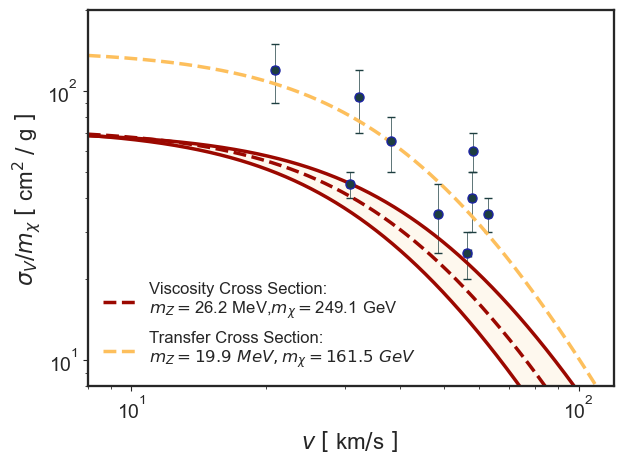

In [ ]:
def sigmav(mchi, mphi, alphax, V):
    w  = 300*(mphi/(10))*(10/(mchi))
    st = (275.73)*(alphax/0.01)**2*(mchi/10.0)*(10.0/(mphi))**(4)
    sv = 3*st*(w**6/(V**6))*((2+V**2/(w**2))*np.log(1+V**2/(w**2))-2*V**2/w**2)
    return sv


#Array for the plot
VX = np.linspace(8, 120, 10000)


def smodel(theta, V):
    param = np.copy(theta)
    return sigmav(*param,V)

high = (209.6 + 39.5, 25.1+1.1, 0.01)
medv = (209, 25.1, 0.01)
low =  (209.6 - 39.5, 25.1-1.1, 0.01)

#SDM = smodel(maxlp, VX)
#Plot the band with error
SDM = smodel(medv,VX)
SDMU = smodel(high,VX)
SDMD = smodel(low,VX)

DM2 = (7, 10, 0.005)
medt = (161.5, 19.9, 0.01)
SDM2 = sigmat(medt[0], medt[1], VX)

        
#Extract from another file for the plot
filname1 = 'Data_1.dat'
V1   = np.loadtxt(filname1, usecols = 1)
VL1  = np.loadtxt(filname1, usecols = 2)
VR1  = np.loadtxt(filname1, usecols = 3)
EV1  = V1-VL1
S1   = np.loadtxt(filname1, usecols = 4)
SD1  = np.loadtxt(filname1, usecols = 5)
SU1  = np.loadtxt(filname1, usecols = 6)
ES1  = S1-SD1
    
plt.errorbar(V1, S1, yerr = ES1, xerr = EV1, capsize=3, capthick=1.0, color=BackgroundColor1,\
                    fmt="o",markersize=6.5,linewidth=0.5,mec=MainColor1 )



plt.plot(VX, SDM, label=r"Viscosity Cross Section:"+ "\n" +"$m_{{Z}} = $" + str(round(high[1], 2)) + "$~$MeV," + r"$m_{{\chi}} =$" + str(round(high[0], 2)) + "$~$GeV", ls='--', linewidth=2.5, color = MainColor2)
plt.plot(VX, SDM2, label=r"Transfer Cross Section:" + "\n" + '$m_{{Z}} ={}~MeV, m_{{\chi}}={}~GeV $'.format(round(medt[1], 2), round(medt[0], 2)), ls='--', linewidth=2.5, color = BackgroundColor3)
plt.plot(VX, SDMU, linewidth=2.5, color = MainColor2)
plt.plot(VX, SDMD, linewidth=2.5, color = MainColor2)
plt.fill_between(VX, SDMU, SDMD,color=BackgroundColor3, alpha=0.1, zorder=0)

plt.xscale('log')
plt.yscale('log')

plt.xlim(8,120)
plt.ylim(8,200)


plt.ylabel(r'$\sigma_V/m_{\chi}$ $[$ cm$^{2}$ $/$ g $]$ ')
plt.xlabel(r'$v$ $[$ km$/$s $]$ ')
plt.legend(loc=3, frameon=False)


sns.set_style('ticks') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('axes', linewidth=1.65 )   # width of the frame
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=12)          # controls default text sizes


plt.tight_layout()
plt.savefig('../Plots/xsec_rcplot.pdf', dpi=300, bbox_inches='tight')
plt.show()


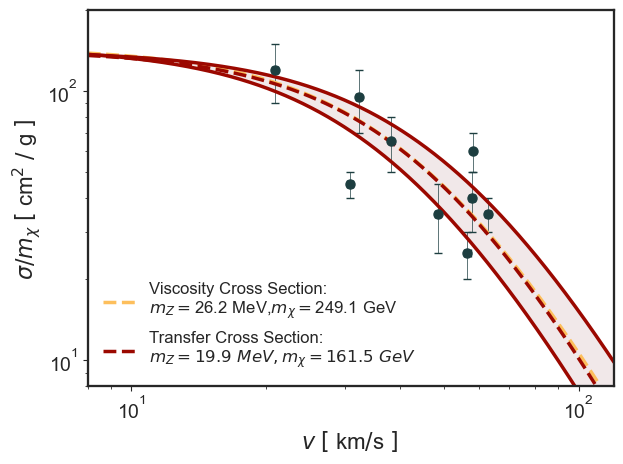

In [26]:
def sigmav(mchi, mphi, alphax, V):
    w  = 300*(mphi/(10))*(10/(mchi))
    st = (275.73)*(alphax/0.01)**2*(mchi/10.0)*(10.0/(mphi))**(4)
    sv = 6*st*(w**6/(V**6))*((2+V**2/(w**2))*np.log(1+V**2/(w**2))-2*V**2/w**2)
    return sv


#Array for the plot
VX = np.linspace(8, 120, 10000)


def smodel(theta, V):
    param = np.copy(theta)
    return sigmav(*param,V)

high = (209.6 + 39.5, 25.1+1.1, 0.01)
medv = (209, 25.1, 0.01)
low =  (209.6 - 39.5, 25.1-1.1, 0.01)

#SDM = smodel(maxlp, VX)
#Plot the band with error
SDM = smodel(medv,VX)
SDMU = smodel(high,VX)
SDMD = smodel(low,VX)

DM2 = (7, 10, 0.005)
medt = (161.5, 19.9, 0.01)
SDM2 = sigmat(medt[0], medt[1], VX)

        
#Extract from another file for the plot
filname1 = 'Data_1.dat'
V1   = np.loadtxt(filname1, usecols = 1)
VL1  = np.loadtxt(filname1, usecols = 2)
VR1  = np.loadtxt(filname1, usecols = 3)
EV1  = V1-VL1
S1   = np.loadtxt(filname1, usecols = 4)
SD1  = np.loadtxt(filname1, usecols = 5)
SU1  = np.loadtxt(filname1, usecols = 6)
ES1  = S1-SD1
    
plt.errorbar(V1, S1, yerr = ES1, xerr = EV1, capsize=3, capthick=1.0, color=BackgroundColor1,\
                    fmt="o",markersize=6.5,linewidth=0.5,mec=BackgroundColor1 )



plt.plot(VX, SDM, label=r"Viscosity Cross Section:"+ "\n" +"$m_{{Z}} = $" + str(round(high[1], 2)) + "$~$MeV," + r"$m_{{\chi}} =$" + str(round(high[0], 2)) + "$~$GeV", ls='--', linewidth=2.5, color = BackgroundColor3)
plt.plot(VX, SDM2, label=r"Transfer Cross Section:" + "\n" + '$m_{{Z}} ={}~MeV, m_{{\chi}}={}~GeV $'.format(round(medt[1], 2), round(medt[0], 2)), ls='--', linewidth=2.5, color = MainColor2)
plt.plot(VX, SDMU, linewidth=2.5, color = MainColor2)
plt.plot(VX, SDMD, linewidth=2.5, color = MainColor2)
plt.fill_between(VX, SDMU, SDMD,color=BackgroundColor2, alpha=0.1, zorder=0)

plt.xscale('log')
plt.yscale('log')

plt.xlim(8,120)
plt.ylim(8,200)


plt.ylabel(r'$\sigma/m_{\chi}$ $[$ cm$^{2}$ $/$ g $]$ ')
plt.xlabel(r'$v$ $[$ km$/$s $]$ ')
plt.legend(loc=3, frameon=False)


sns.set_style('ticks') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('axes', linewidth=1.65 )   # width of the frame
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=12)          # controls default text sizes


plt.tight_layout()
plt.savefig('../Plots/xsec_rcplot.pdf', dpi=300, bbox_inches='tight')
plt.show()


## Fits With Transfer Cross Section

In [ ]:
def GOPT(name, init, nwalkers = 48, 
           steps = 2000, burn = 0, opstps = 1000, sig = 0.1, sigp = 0.1):
        
        #DM only rotation curve
        def smodel(theta, V):
            param = np.copy(theta)
            param = 10**param
            return sigmat(*param,V)

        #log-prior, here theta = (lmchi, lalpha)
        def lprior(theta, V):
            return logp(*theta, V)

        #log-likelihood function
        def llhood(theta, V, S, ES, EV):
            #angular dependence
            param = np.copy(theta)
            model = smodel(theta, V)
            sigma2 = ES**2
            return -0.5*np.sum((S - model)**2 / sigma2)

        #log-posterior function
        def lpost(theta, V, S, ES, EV):
        
            lp = lprior(theta, V);

            #discards parameters not satisfying the log-prior conditions
            if not np.isfinite(lp): 
                return -np.inf

            llh = llhood(theta, V, S, ES, EV);

            #discards mathematically unsound parameters (those yielding square roots of negative numbers etc.)
            if np.any(np.isnan(lp + llh)) == True: 

                return -np.inf

            return lp + llh
        
        
        #Load Data
        filname = 'Data.dat'
        V   = np.loadtxt(filname, usecols = 1)
        VL  = np.loadtxt(filname, usecols = 2)
        VR  = np.loadtxt(filname, usecols = 3)
        EV  = V-VL
        S   = np.loadtxt(filname, usecols = 4)
        SD  = np.loadtxt(filname, usecols = 5)
        SU  = np.loadtxt(filname, usecols = 6)
        ES  = S-SD
        
        ndim = 2
        n = len(S)    
        rand = np.random.randn(nwalkers, ndim)

        #This avoids error messages when the parameters yield mathematically unsound results (square roots of 
        #negative numbers etc.), these will be discarded from the parameter space, but are computed so #
        #that they can be evaluated
        with warnings.catch_warnings(): 
            warnings.simplefilter('ignore')
            #"refined" initial guess (in case the initial one has divergent log-posterior probability or is 
            #sub-optimal with respect to the log-posterior probability)

            print( " ")
            print("Result for initial maximum log-posterior estimate:")
            print( " ")
            init = optimizer(name, lpost, init, ndim, opstps, sig) # compute new optimized initial guess parameters of the parameters

            linit = lpost(init, V, S, ES, EV) #Log of initial guess is now the log of posterior probability
            thresh= log(100) # ???

            for val in rand:  #loop over walkers
                for i in range(ndim): #loop over paramters
                    val[i] *= sigp*init[i] #(sigp = 0.1), significance level for initial param estimation
                ipval =  init + val 
                lpval = lpost(ipval, V, S, ES, EV)
                while linit - lpval > thresh:
                    val *= 0.5
                    ipval = init + val
                    lpval = lpost(ipval, V, S, ES, EV)


            pos = init + rand;

            filename = str(name + "_mcmc_chain")


        #  def lpostg(theta):
        #    return lpost(theta, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa)

            max_n = steps + burn
            min_n = 2*burn

            sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost,
                        args = (V, S, ES, EV),
                                           moves=[(emcee.moves.DEMove(), 0.8),
                                                (emcee.moves.DESnookerMove(), 0.2),])

            # We'll track how the average autocorrelation time estimate changes
            index = 0
            autocorr = np.empty(max_n)

            # This will be useful to testing convergence
            old_tau = np.inf

            # Now we'll sample for up to max_n steps
            for sample in sampler.sample(pos, iterations=max_n, progress=True):
                # Only check convergence every 100 steps
                if sampler.iteration % 100:
                    continue

                # Compute the autocorrelation time so far
                # Using tol=0 means that we'll always get an estimate even
                # if it isn't trustworthy
                tau = sampler.get_autocorr_time(tol=0)
                autocorr[index] = np.mean(tau)
                index += 1

                # Check convergence
                converged = np.all((tau * 100) < sampler.iteration)
                converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
                converged &= np.all(min_n <= sampler.iteration)
                if converged:
                    break
                old_tau = tau
            

            tau = sampler.get_autocorr_time(quiet = True)
            print( " ")
            print('Autocorrelation time 1 = ', tau)
            print( " ")
            print("Mean acceptance fraction 1 = ", np.mean(sampler.acceptance_fraction))
            print( " ")
            flat_samples = sampler.get_chain(discard=burn, flat=True)

            logs = sampler.get_log_prob(discard=burn, flat=True)

            ind = logs.argsort()

            sorsam = flat_samples[ind]

            maxlp = sorsam[-1]
            
            print("Global optimum from initial chain: ")
            print(" ")
            print(maxlp, "[log-prob. = ", max(logs) ,"]")
            print(" ")
            #return [maxlp, max(tau)]
            return maxlp #return the maximum log probability optimized
           

In [20]:
# Main Function to perform an optimized Markov Chain Montecarlo Fit,
# It requires: 
# init: Initial guess for the parameters
# savechain: 
# nwalkers: Number of MCMC walkers.
# steps: Number of MCMC steps.
# burn: Number of burn-in steps.
# maxstps: Maximum number of steps for the initial estimation.
# opstps: Number of steps for the initial estimation.
# sig: Significance level.
# folder: Folder to save the output.
# sigp: Significance level for initial estimation.
# err: Whether to compute errors.

def GGMCMC(init, savechain = False, nwalkers = 48, 
           steps = 10000, burn = 1000, maxstps = 2000, opstps = 10000, sig = 0.1, sigp = 0.1, folder = None, err = False):
   
    #What is doing this variable?
    name = "xsecvalpha" 
        
    #File where the cross sections data lies
    filename = 'Data.dat'

    #DM only rotation curve (???). 
    # Theta refers to the parameters of the fit (in log scale): theta = (lmchi, lalpha)
    
    def smodel(theta, V):
        param = np.copy(theta)
        param = 10**param # This line transforms the parameters to its original scale
        return sigmat(*param,V)
    
    #define log-prior
    def lprior(theta, V):
        return logp(*theta, V)

    #define the logarithm of the likelihood function (the probability of the data given the model)
    def llhood(theta, V, S, ES, EV):
        #angular dependence
        param = np.copy(theta)
        model = smodel(theta, V)
        sigma2 = ES**2 #std dev in cross section
        return -0.5*np.sum((S - model)**2 / sigma2) # - 1/2 chi2, S: data
        
    #log-posterior function
    def lpost(theta, V, S, ES, EV):

        lp = lprior(theta, V) # this is 0 or -inf

        #discards parameters not satisfying the log-prior conditions (ranges where the prior probability is zero)
        # means:
        # if lprior = -inf -> lposterior = - inf 
        # in turn means that if we consider paramters ouside range of interest, the posterior probability,
        # (probability of the model given the data), is zero. 
        if not np.isfinite(lp): 
            return -np.inf

        # otherwise, if lprior = 0, then log-post = log-likelihood
        llh = llhood(theta, V, S, ES, EV)

        #discards mathematically unsound parameters (those yielding square roots of negative numbers etc.)
        if np.any(np.isnan(lp + llh)) == True: 

            return -np.inf

        #the function at the end is 
        # log(posterior) = log(prior) + log(likelihood), equivalent to
        # P_posterior = P_prior * Likelihood (Bayes theorem)
        return lp + llh
    
        #Load data from file
    V   = np.loadtxt(filename, usecols = 1)
    VL  = np.loadtxt(filename, usecols = 2)
    VR  = np.loadtxt(filename, usecols = 3)
    EV  = V-VL
    S   = np.loadtxt(filename, usecols = 4)
    SD  = np.loadtxt(filename, usecols = 5)
    SU  = np.loadtxt(filename, usecols = 6)
    ES  = S-SD
        
    n = len(S) #Number of data points
    ndim = 2 #Number of dimensions (of parameters)
    rand = np.random.randn(nwalkers, ndim) #generates an array of walkers for both parameters

    #This avoids error messages when the parameters yield mathematically unsound results (square roots of 
    #negative numbers etc.), these will be discarded from the parameter space, but are computed so 
    #that they can be evaluated
        
    with warnings.catch_warnings(): 
        warnings.simplefilter('ignore')
        #"refined" initial guess (in case the initial one has divergent log-posterior probability or is 
        #sub-optimal with respect to the log-posterior probability)
        print( " ")
        print("Result for maximum log-posterior estimate:")
        print( " ")

        init = GOPT(name, init, nwalkers = nwalkers, 
        steps = maxstps, burn = burn, opstps = opstps, sig = sig, sigp = sigp) #return the maximim log probability optimized

        linit = lpost(init, V, S, ES, EV) #log of initial guess parameters
        thresh= log(100)


        for val in rand:
            for i in range(ndim):
                val[i] *= sigp*init[i]
            ipval =  init + val 
            lpval = lpost(ipval, V, S, ES, EV)
            while linit - lpval > thresh:
                val *= 0.5
                ipval = init + val
                lpval = lpost(ipval, V, S, ES, EV)


            pos = init + rand;

            filename = str(name + "_mcmc_chain")
            
            conv = False

            
            
            #if savechain == True:
                 #   print("Chain saved")
                #    backend = emcee.backends.HDFBackend(filename)
                  #  backend.reset(nwalkers, ndim)

                  #  sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, backend = backend,\
                  #                                  args = (R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa),
                  #                                 moves=[
            #(emcee.moves.DEMove(), 0.8),
            #(emcee.moves.DESnookerMove(), 0.2),
       # ]);

            #else:
                    
        max_n = steps 
        min_n = 2*burn

        sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost,
                    args = (V, S, ES, EV),
                    moves=[ 
                    (emcee.moves.DEMove(), 0.8),
                    (emcee.moves.DESnookerMove(), 0.2),
                    ]);

    # We'll track how the average autocorrelation time estimate changes
    #index = 0
    #autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf
    
    taus = []

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
            # Only check convergence every 100 steps
            if sampler.iteration % 100:
                continue

            # Compute the autocorrelation time so far
            # Using tol=0 means that we'll always get an estimate even
            # if it isn't trustworthy
            tau = sampler.get_autocorr_time(tol=0)
            taus.append(np.mean(tau))
            #autocorr[index] = np.mean(tau)
            #index += 1

            # Check convergence
            converged = np.all((tau * 100) < sampler.iteration)
            converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
            converged &= np.all(min_n <= sampler.iteration)
            if converged:
                burn = int(sampler.iteration/2)
                conv = True
                break
            old_tau = tau



    #Plot Autocorrelation time
    if conv == False:
                burn = int(steps/2)

    plt.title(r'Mean Autocorrelation Time vs Steps', fontsize = 0.5*size)

    stepa = np.linspace(1, len(taus), len(taus))*100
    taus = np.array(taus)

    plt.plot(stepa, stepa/100, label = r'$\hat{\tau}= N/100$')
    #plt.plot(stepa, stepa/50, label = r'$\hat{\tau} = N/50$')
    plt.legend(fontsize = 0.5*size)
    
    plt.xlabel(r'$N$', fontsize = 0.5*size)
    plt.ylabel(r'$\hat{\tau}$', fontsize = 0.5*size)
    plt.plot(stepa, taus)
    

    if folder == None:
        plt.savefig(str("Parameters/" + name + "_tau.pdf"))
    plt.show()
    
    print("Burn-in period = ", burn," steps")
    tau = sampler.get_autocorr_time(quiet = True)

    print( " ")
    print('Autocorrelation time = ', tau)
    print( " ")
    print("Mean acceptance fraction = ", np.mean(sampler.acceptance_fraction))
    print( " ")

    flat_samples = sampler.get_chain(discard=burn, flat=True)

    low = []
    high = []
    med = []
    maxr = []
    minr = []
    min95 = []
    max95 = []
    
    labels = [r'$m_{\chi}$ [GeV]',r'$m_{\phi}$ [MeV]',r'$\alpha_{X}$']
    labels1 = [r'$m_{\chi}$',r'$m_{\phi}$',r'$\alpha_{X}$']
    print( " ")
    print("Medians within 65% of the sample:")
    print( " ")
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84, 0.1, 99.9, 2.5, 97.5])
        q = np.diff(mcmc)
        low.append(mcmc[1] - q[0])
        high.append(mcmc[1] + q[1])
        med.append(mcmc[1])
        minr.append(mcmc[3])
        maxr.append(mcmc[4])
        min95.append(mcmc[5])
        max95.append(mcmc[6])
        print( " ")
        print(labels[i]," ", mcmc[1], " ", q[0], " ", q[1])
        print( " ")

    logs = sampler.get_log_prob(discard=burn, flat=True)

    ind = logs.argsort()

    sorsam = flat_samples[ind]

    maxlp = sorsam[-1]
    lp32 = sorsam[int(0.32*len(sorsam))]
    minlp = sorsam[0]
    print(" ")
    print("Maximum posterior values = ", maxlp)
    print(" ")
    print("32 percentile posterior values = ", lp32)
    print(" ")
    print("Minimum posterior values = ", minlp)

    sor68 = sorsam[int(0.32*len(sorsam) - 1):]
    minres = np.inf
    maxres = -np.inf
    
    sor95 = sorsam[:int(0.32*len(sorsam))]

#         mint = None

#         maxt = None

    #Normalised residuals
    def normres(theta, V, S, ES, EV):
        param = np.copy(theta)
        model = smodel(*param, V);
        sigma2 = ES**2
        return np.sum((model - S) / sigma2)



    fsan = np.copy(flat_samples)

    for i in range(len(fsan)):
            fsan[i]= 10**fsan[i]

    maxsan = np.copy(maxlp)




    #corner plots
    #plt.rcParams['text.usetex'] = True

    fig = corner.corner(fsan, labels=labels1, truths=maxsan, fontsize = 1.4*size,\
    quantiles = (0.16, 0.5, 0.84), color ='royalblue', \
    show_titles=True, title_fmt='.2f', use_math_text=True, title_kwargs=dict(fontsize=16));
        
    for ax in fig.get_axes():  
        ax.tick_params(axis='both', labelsize=16)
        ax.xaxis.label.set_size(18)
        ax.yaxis.label.set_size(18)
        ax.xaxis.label.set_family('serif')
        ax.yaxis.label.set_family('serif')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.75)
    
    #NAME = name.upper()
    #plt.suptitle("MW ",fontsize=24, color='deepskyblue', x=0.7, y=0.9)


    if folder == None:
        namec = str("Corner Plots/" + name + "_corner.pdf")
        plt.savefig(namec)
    plt.show()

    n = len(S)    

    low = np.array(low)
    high = np.array(high)
    med = np.array(med)
    maxr = np.array(maxr)
    minr = np.array(minr)
    print( " ")
    print("99.9 parameter percentile values = ", maxr)
    print( " ")
    print("0.1 parameter percentile values = ", minr)
    print( " ")
    print("97.5 parameter percentile values = ", max95)
    print( " ")
    print("2.5 parameter percentile values = ", min95)


    #Chi-square function
    def chi2(theta, V, S, ES, EV):
        param = np.copy(theta)
        model = smodel(theta, V);
        sigma2 = ES**2
        return np.sum((S-model)**2 / sigma2)

#         def rllhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV):

#             count = 0

#             for i in range(len(theta)):
#                 if minr[i]<= theta[i] <= maxr[i]:
#                     count += 1
#             if count == len(theta):
#                 return llhood(theta, R, Vobs, Vgas, Vdisk, Vbul, errV)

#             else:
#                 return -np.inf 

    valhoods = np.ones(len(flat_samples))
    for i in range(len(flat_samples)):
        valhoods[i] = llhood(flat_samples[i], V, S, ES, EV)    

    lind = valhoods.argsort()
    lsorsam = flat_samples[ind]

    print(" ")
    chipost = chi2(maxlp, V, S, ES, EV)/(n - ndim )
    print("Reduced chi-square of maximum posterior = ", chipost)
    print(" ")  
    print("Log-posterior of maximum posterior = ",\
            lpost(maxlp, V, S, ES, EV))
    print(" ")       
    print("Reduced chi-square of 32 percentile posterior = ",\
            chi2(lp32, V, S, ES, EV)/(n - ndim ))
    print(" ") 
    print("Log-posterior of 32 percentile posterior = ",\
            lpost(lp32, V, S, ES, EV))
    print(" ")
    print("Reduced chi-square of minimum posterior = ",\
            chi2(minlp, V, S, ES, EV)/(n - ndim ))
    print(" ") 
    print("Log-posterior of minimum posterior = ",\
            lpost(minlp, V, S, ES, EV))  
    print(" ")
    print("Log-posterior of 2.5 percentile parameters = ",\
            lpost(min95, V, S, ES, EV))  
    print(" ")
    print("Log-posterior of 97.5 percentile parameters = ",\
            lpost(max95, V, S, ES, EV))  
    print(" ")

#         print("Reduced chi-square of 32 percentile min. norm. residuals = ",\
#               chi2(mint, R, Vr, errVr, Va, errVa)/(n - ndim ))
#         print(" ") 
#         print("Log-posterior of 32 percentile min. norm. residuals = ",\
#               lpost(mint, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa))   
#         print(" ")
#         print("Reduced chi-square of 32 percentile max. norm. residuals  = ",\
#               chi2(maxt, R, Vr, errVr, Va, errVa)/(n - ndim ))
#         print(" ") 
#         print("Log-posterior of 32 percentile max. norm. residuals = ",\
#               lpost(maxt, R, mgas, rst, rgas, mst0, errmst0, Vr, errVr, Va, errVa))   

    mle = lsorsam[-1]
    print( " ")
    print("MLE parameters = ", mle)
    #init2 = optimizer(name, rllhood, med, ndim, opstps, sig)

    print( " ")
    rchi =  chi2(mle, V, S, ES, EV)/(n - ndim )
    print("Reduced chi-square of MLE = ", rchi)
    print(" ") 
    print("Log-posterior of MLE = ",\
            lpost(mle, V, S, ES, EV))
    print( " ")
    bic = chi2(mle, V, S, ES, EV) + ndim*log(n)
    print("BIC (up to a constant, at MLE) = ", bic)
    print( " ")
    print("Reduced chi-square of 0.1 percentile parameters = ",\
            chi2(minr, V, S, ES, EV)/(n - ndim ))
    print("Reduced chi-square of 2.5 percentile parameters = ",\
            chi2(min95, V, S, ES, EV)/(n - ndim ))

    print( " ")
    print("Reduced chi-square of 16 percentile parameters = ",\
            chi2(low, V, S, ES, EV)/(n - ndim ))
    print( " ")
    print("Reduced chi-square of 50 percentile (median) = ",\
            chi2(med, V, S, ES, EV)/(n - ndim ))
    print(" ") 
    print("Log-poslterior of 50 percentile (median) = ",\
            lpost(med, V, S, ES, EV))
    print(" ")
    print("Reduced chi-square of 84 percentile parameters = ",\
            chi2(high, V, S, ES, EV)/(n - ndim ))
    print( " ")
    print("Reduced chi-square of 97.5 percentile parameters = ",\
            chi2(max95, V, S, ES, EV)/(n - ndim ))
    print( " ")
    print("Reduced chi-square of 99.9 percentile parameters = ",\
            chi2(maxr, V, S, ES, EV)/(n - ndim ))
    print( " ")

    #rotation curves
    fig, ax = plt.subplots(figsize=(10,8))
        
    #Extract from another file for the plot
    filname1 = 'Data_1.dat'
    V1   = np.loadtxt(filname1, usecols = 1)
    VL1  = np.loadtxt(filname1, usecols = 2)
    VR1  = np.loadtxt(filname1, usecols = 3)
    EV1  = V1-VL1
    S1   = np.loadtxt(filname1, usecols = 4)
    SD1  = np.loadtxt(filname1, usecols = 5)
    SU1  = np.loadtxt(filname1, usecols = 6)
    ES1  = S1-SD1
        
    ax.errorbar(V1, S1, yerr = ES1, xerr = EV1, capsize=4, capthick=1.0, color=Gray1,\
                    fmt="o",markersize=10.5,linewidth=0.5,mec=MainColor1 )


    if err == True:


        maxvs_c = list(np.ones(n))
        minvs_c = list(np.ones(n))
        maxvs = np.ones(n)*-np.inf
        minvs = np.ones(n)*np.inf

        for theta in sor68:
            vth = smodel(theta,  V)

            for i in range(n):
                if vth[i] > maxvs[i]:
                    maxvs[i] = vth[i]
                    maxvs_c[i] = theta

                if vth[i] < minvs[i]:
                    minvs[i] = vth[i]
                    minvs_c[i] = theta
                    
        maxvs95_c = list(np.ones(n))
        minvs95_c = list(np.ones(n))  
        maxvs95 = np.ones(n)*-np.inf
        minvs95 = np.ones(n)*np.inf
        
        for theta in sor95:

            vth = smodel(theta,  V)

            for i in range(n):
                if vth[i] > maxvs95[i]:
                    maxvs95[i] = vth[i]
                    maxvs95_c[i] = theta

                if vth[i] < minvs95[i]:
                    minvs95[i] = vth[i]
                    minvs95_c[i] = theta
                    
                    
        for i in range(n):
                
                if maxvs95[i] < maxvs[i]:
                    maxvs95[i] = maxvs[i]
                    maxvs95_c[i] = maxvs_c[i]


                if minvs95[i] > minvs[i]:
                    minvs95[i] = minvs[i]
                    minvs95_c[i] = minvs_c[i]            
              
        
    #plt.fill_between(R, vmodel(*mint, R, Vgas, Vdisk, Vbul), vmodel(*maxt, R, Vgas, Vdisk, Vbul),\
                    #  color='red', alpha=0.2, zorder=0)

#                 len68 = len(sor68)
#                 for i in range(100):
#                     theta = sor68[np.random.randint(1, len68)]
#                     ax.plot(R, vmodel(*theta, R, Vgas, Vdisk, Vbul), color='red', alpha=0.2, linewidth = 1)
    
    
    #Array for the plot
    VX = np.linspace(8, 120, 10000)

    #SDM = smodel(maxlp, VX)
    #Plot the band with error
    SDM = smodel(med,VX)
    SDMU = smodel(high,VX)
    SDMD = smodel(low,VX)
    
    ax.set_title('Fit with Transfer Cross Section')
    ax.plot(VX, SDM, label=r'$m_{{Z}} ={}~MeV, m_{{\chi}}={}~GeV $'.format(round(med[1], 2), round(med[0], 2)), ls='--', linewidth=2.5, color = MainColor2)
    ax.plot(VX, SDMU, linewidth=2.5, color = MainColor2)
    ax.plot(VX, SDMD, linewidth=2.5, color = MainColor2)

    plt.fill_between(VX, SDMU, SDMD,color=BackgroundColor3, alpha=0.1, zorder=0)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlim(8,120)
    plt.ylim(8,200)
    
    ax.legend(loc=3, frameon=False)
    plt.ylabel(r'$\sigma_T/m_{\chi}$ $[$ cm$^{2}$ $/$ g $]$ ')
    plt.xlabel(r'$v$ $[$ km$/$s $]$ ')
    #plt.xticks(fontsize = 0.9*size)
    #plt.yticks(fontsize = 0.9*size)
    #ax.tick_params('both', length=8.5, width=1.7, which='major', direction="in")
    #ax.tick_params('both', length=5, width=1.4, which='minor', direction="in")
    #axx = ax.secondary_yaxis("right");
    #axy = ax.secondary_xaxis("top");
    #axx.tick_params('both', length=8.5, width=1.7, which='major', direction="in", labelright=False, labeltop=False)
    #axx.tick_params('both', length=5, width=1.4, which='minor', direction="in")
    #axy.tick_params('both', length=8.5, width=1.7, which='major', direction="in", labelright=False, labeltop=False)
    #axy.tick_params('both', length=5, width=1.4, which='minor', direction="in")
    #plt.legend(fontsize = size*0.7, frameon=False)
    
    
    #ax.annotate(r'$\alpha=0.01$', xy = (10,15), xytext=(10, 15), fontsize = size)
        
    
    #NAME = name.upper()
    #plt.title(r'$\sigma$ vs v', fontsize = size)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.75)

        
    oar = np.linspace(1, 10**4, 10**4)

    namef = str("xsec/xsec_rcplot_transfer.pdf")
    plt.savefig(namef)


    maxlpdf = pd.DataFrame({})
    for i in range(len(maxlp)):
        maxlpdf[str(oar[i])]=[maxlp[i]]

    minvsdf = pd.DataFrame({})
    for i in range(len(minvs)):
        minvsdf[str(oar[i])]=[minvs[i]]

    maxvsdf = pd.DataFrame({})
    for i in range(len(maxvs)):
        maxvsdf[str(oar[i])]=[maxvs[i]]
            
    minvs95df = pd.DataFrame({})
    for i in range(len(minvs95)):
        minvs95df[str(oar[i])]=[minvs95[i]]

    maxvs95df = pd.DataFrame({})
    for i in range(len(maxvs95)):
        maxvs95df[str(oar[i])]=[maxvs95[i]]    
            

    tausdf = pd.DataFrame({})
    for i in range(len(taus)):
        tausdf[str(oar[i])]=[taus[i]]    

    minvsdf.to_csv("Parameters/" + name + "_minvs.csv", index = False, sep = ' ')
    maxvsdf.to_csv("Parameters/" + name + "_maxvs.csv", index = False, sep = ' ')  
    tausdf.to_csv("Parameters/" + name + "_taus.csv", index = False, sep = ' ')
        
    minvs95df.to_csv("Parameters/" + name + "_minvs95.csv", index = False, sep = ' ')
    maxvs95df.to_csv("Parameters/" + name + "_maxvs95.csv", index = False, sep = ' ')  



    if  ndim == 2:

            mdmdf = pd.DataFrame({"ma":[10**med[0]], "mah":[10**high[0]], "mal":[10**low[0]],
                                    "max95":[10**max95[0]], "min95":[10**min95[0]]})
            mphidf = pd.DataFrame({"mc":[10**med[1]], "mch":[10**high[1]], "mcl":[10**low[1]],
                                "max95":[10**max95[1]], "min95":[10**min95[1]]})
            #alphadf = pd.DataFrame({"c":[10**med[2]], "ch":[10**high[2]], "cl":[10**low[2]],
                #                   "max95":[10**max95[2]], "min95":[10**min95[2]]})

            bicdf = pd.DataFrame({"bic":[bic]})
            rchidf = pd.DataFrame({"rchipost":[chipost]})
            #maxlpdf = pd.DataFrame({"maxpost":[maxlp]})

            mchi = 10**med[0]
            mphi  = 10**med[1]
            #alph   = 10**med[2]
        
            mdm1  = 10**maxlp[0]
            mint = 10**maxlp[1]
            #alpx = 10**maxlp[2]
    

            mdmdf.to_csv("Parameters/" + name + "_Mchi.csv", index = False, sep = ' ')
            mphidf.to_csv("Parameters/" + name + "_Mphi.csv", index = False, sep = ' ')
            #alphadf.to_csv("/Parameters/" + name + "_alphax.csv", index = False, sep = ' ')
            #mdm1.to_csv("Parameters/" + name + "_Mchiml.csv", index = False, sep = ' ')
            #mint.to_csv("Parameters/" + name + "_mintml.csv", index = False, sep = ' ')
            #alpx.to_csv("/Parameters/" + name + "_alpxml.csv", index = False, sep = ' ')
            bicdf.to_csv("Parameters/" + name + "_bic.csv", index = False, sep = ' ')
            rchidf.to_csv("Parameters/" + name + "_rchipost.csv", index = False, sep = ' ')
            maxlpdf.to_csv("Parameters/" + name + "_maxpost.csv", index = False, sep = ' ')
        
        
        
        
    if  ndim == 3:

            mdmdf = pd.DataFrame({"ma":[10**med[0]], "mah":[10**high[0]], "mal":[10**low[0]],
                                    "max95":[10**max95[0]], "min95":[10**min95[0]]})
            mphidf = pd.DataFrame({"mc":[10**med[1]], "mch":[10**high[1]], "mcl":[10**low[1]],
                                "max95":[10**max95[1]], "min95":[10**min95[1]]})
            alphadf = pd.DataFrame({"c":[10**med[2]], "ch":[10**high[2]], "cl":[10**low[2]],
                                "max95":[10**max95[2]], "min95":[10**min95[2]]})

            bicdf = pd.DataFrame({"bic":[bic]})
            rchidf = pd.DataFrame({"rchipost":[chipost]})
            #maxlpdf = pd.DataFrame({"maxpost":[maxlp]})

            mchi = 10**med[0]
            mphi  = 10**med[1]
            alph   = 10**med[2]
        

            

            mdm1 = 10**maxlp[0]
            mint = 10**maxlp[1]
            alpx = 10**maxlp[2]
        

            


            mdmdf.to_csv("/Parameters/" + name + "_Mchi.csv", index = False, sep = ' ')
            mphidf.to_csv("/Parameters/" + name + "_Mphi.csv", index = False, sep = ' ')
            alphadf.to_csv("/Parameters/" + name + "_alphax.csv", index = False, sep = ' ')
            #mdm1.to_csv("/Parameters/" + name + "_Mchiml.csv", index = False, sep = ' ')
            #mint.to_csv("/Parameters/" + name + "_mintml.csv", index = False, sep = ' ')
            alpx.to_csv("/Parameters/" + name + "_alpxml.csv", index = False, sep = ' ')
            bicdf.to_csv("/Parameters/" + name + "_bic.csv", index = False, sep = ' ')
            rchidf.to_csv("/Parameters/" + name + "_rchipost.csv", index = False, sep = ' ')
            maxlpdf.to_csv("/Parameters/" + name + "_maxpost.csv", index = False, sep = ' ')
    plt.show()


In [21]:
# initial_guess
initial_guess = np.array([-1,-1])


GGMCMC(initial_guess, err = False)

 
Result for maximum log-posterior estimate:
 
 
Result for initial maximum log-posterior estimate:
 


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()